In [89]:
import json
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import matplotlib.cm as cm
import numpy as np
import pandas as pd
from collections import defaultdict

In [90]:
# Obtain Dice results
with open('/home/t722s/Desktop/Sam-Med3DTest/NetworkHeartModified/original.json', 'r') as f:
    original = json.load(f)

with open('/home/t722s/Desktop/Sam-Med3DTest/NetworkHeartModified/interactive.json', 'r') as f:
    interactive = json.load(f)

with open('/home/t722s/Desktop/Sam-Med3DTest/NetworkHeartModified/presupplied.json', 'r') as f:
    presupplied = json.load(f)

# Get brats baseline: requires reformatting
with open('/home/t722s/Desktop/Sam-Med3DTest/evalBrats/point_crop_not_interactive.json', 'r') as f:
    brats_baseline = json.load(f)

brats_baseline = {k: {str(i):v['dice'][i] for i in range(5)} for k,v in brats_baseline.items()}
brats_baseline = {k: {'Brain Tumor' : v} for k,v in brats_baseline.items()}
brats_baseline = {k: {'BraTS2021_01646.nii.gz' : v} for k,v in brats_baseline.items()}



res_dict = {'original': original,
            'interactive': interactive,
            'presupplied': presupplied,
            'brats presupplied': brats_baseline}

In [91]:
n_click = 4

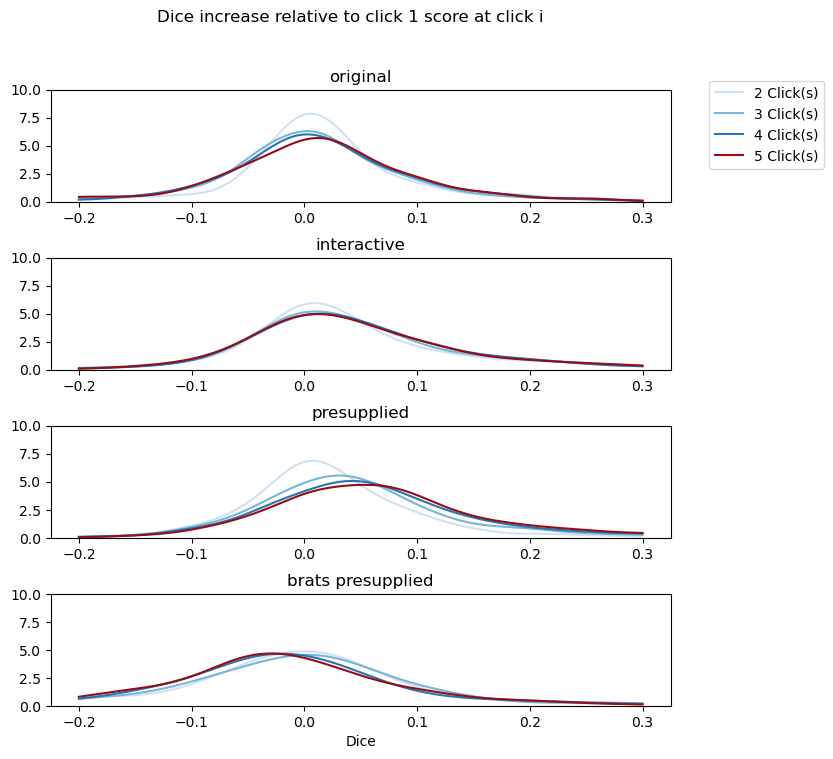

In [92]:
# Value added by clicks 1 through n relative to n 
organ = 'left atrium'
diffs_dict = dict()
for protocol, res in res_dict.items():
    diff_to_first = defaultdict(list)
    for seed_res in res.values():
        for file_res in seed_res.values():
            for organ_res in file_res.values():
                for i in range(1,5):
                    diff_to_first[i].append(organ_res[str(i)] - organ_res['0'])
    diffs_dict[protocol] = diff_to_first

# Common plotting elements
n_click = 4
x_range = np.linspace(-0.2, 0.3, 500)
color_start = 0.2  # Start from a darker shade
color_end = 1  # End before the darkest shade to keep a uniform intensity
colors = [cm.Blues(i / (n_click-1) * (color_end - color_start) + color_start) for i in range(n_click-1)]
colors.append(cm.Reds(0.9))

fig, ax = plt.subplots(len(diffs_dict),1, figsize = (8,8))
plt.subplots_adjust(hspace=0.5, right=0.9)

for i, (protocol, res) in enumerate(diffs_dict.items()):
    for click, diffs in res.items():
        kde = gaussian_kde(diffs)
        kde_values = kde(x_range)
        
        # Plot each row's KDE with a different color
        # ax.plot(x_range, kde_values, color=colors[click-1], label=f'{click} Click(s)')
        ax[i].plot(x_range, kde_values, color=colors[click-1], label=f'{click+1} Click(s)')

    # ax.set_title(protocol)
    # ax.set_xlabel(None)
    # ax.set_ylabel(None)
    # ax.set_ylim([0,7.5])

    ax[i].set_title(protocol)
    ax[i].set_xlabel(None)
    ax[i].set_ylabel(None)
    ax[i].set_ylim([0,10])

    if i == 0: 
        fig.legend(loc = 'upper right', bbox_to_anchor=(1.1, 0.9))

ax[i].set_xlabel('Dice')
fig.suptitle('Dice increase relative to click 1 score at click i')
plt.show()


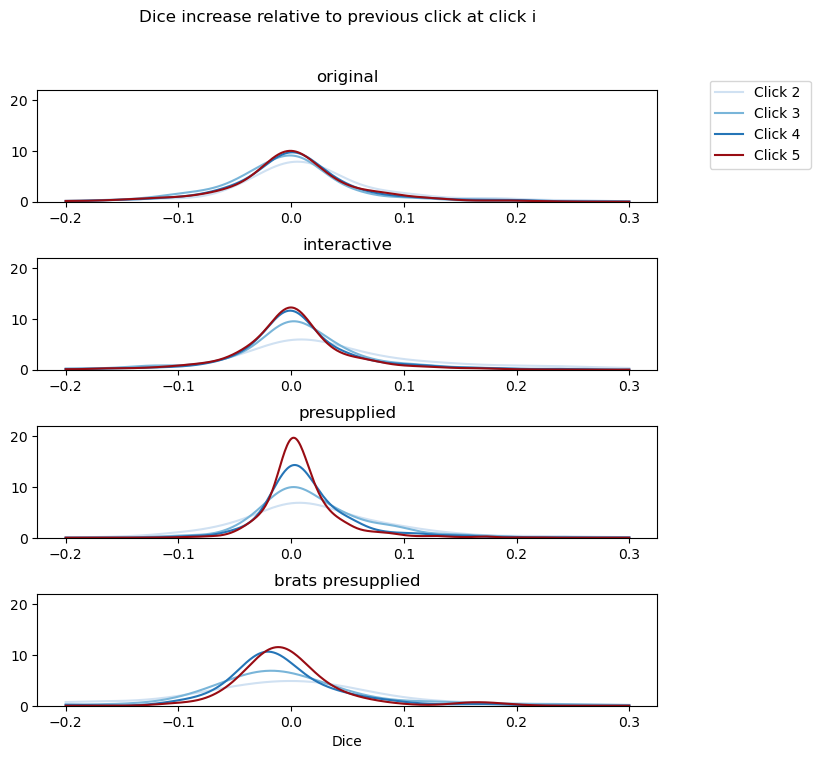

In [93]:
# Value added by nth click relative to n-1th click dice
diffs_prev_dict = dict()
for protocol, res in res_dict.items():
    diff_to_prev = defaultdict(list)
    for seed_res in res.values():
        for file_res in seed_res.values():
            for organ_res in file_res.values():
                for i in range(1,5):
                    diff_to_prev[i].append(organ_res[str(i)] - organ_res[str(i-1)])
    diffs_prev_dict[protocol] = diff_to_prev

# Common plotting elements
n_click = 4
x_range = np.linspace(-0.2, 0.3, 500)
color_start = 0.2  # Start from a darker shade
color_end = 1  # End before the darkest shade to keep a uniform intensity
colors = [cm.Blues(i / (n_click-1) * (color_end - color_start) + color_start) for i in range(n_click-1)]
colors.append(cm.Reds(0.9))

fig, ax = plt.subplots(len(diffs_dict),1, figsize = (8,8))
plt.subplots_adjust(hspace=0.5, right=0.9)

for i, (protocol, res) in enumerate(diffs_prev_dict.items()):
    for click, diffs in res.items():
        kde = gaussian_kde(diffs)
        kde_values = kde(x_range)
        
        # Plot each row's KDE with a different color
        # ax.plot(x_range, kde_values, color=colors[click-1], label=f'{click} Click(s)')
        ax[i].plot(x_range, kde_values, color=colors[click-1], label=f'Click {click+1} ')

    # ax.set_title(protocol)
    # ax.set_xlabel(None)
    # ax.set_ylabel(None)
    # ax.set_ylim([0,7.5])

    ax[i].set_title(protocol)
    ax[i].set_xlabel(None)
    ax[i].set_ylabel(None)
    ax[i].set_ylim([0,22])

    if i == 0: 
        fig.legend(loc = 'upper right', bbox_to_anchor=(1.1, 0.9))

ax[i].set_xlabel('Dice')
fig.suptitle('Dice increase relative to previous click at click i')
plt.show()


In [109]:
dice = dict()
for protocol, res in res_dict.items():
    vals = defaultdict(list)
    for seed_res in res.values():
        for file_res in seed_res.values():
            for organ_res in file_res.values():
                for i in range(5):
                    vals[i].append(organ_res[str(i)])
    dice[protocol] = vals

summary = dict()
df = pd.DataFrame(columns = ['protocol', 'n clicks', 'min', '1st', 'med', 'mean', '3rd', 'std'])
for protocol, res in dice.items():
    summary[protocol] = dict()
    for i, row in res.items():
        d = dict()
        d = {
            'protocol': protocol,
            'n clicks': i+1,
            'min': np.min(row),
            '1st': np.quantile(row, 0.25),
            'med': np.median(row),
            'mean': np.mean(row),
            '3rd': np.quantile(row, 0.75),
            'std': np.std(row)
        }
        df.loc[len(df)] = d
        summary[protocol][f'click{i+1}']=d

df = df.round(decimals=4)
#display(df)
display(df[(df['n clicks']==5) & (df['protocol'] != 'brats presupplied')])

,protocol,n clicks,min,1st,med,mean,3rd,std
4,original,5,0.0598,0.5864,0.6324,0.6185,0.6748,0.0914
9,interactive,5,0.1990,0.5914,0.6345,0.6313,0.6731,0.0772
14,presupplied,5,0.0836,0.6045,0.6530,0.6469,0.6989,0.0751


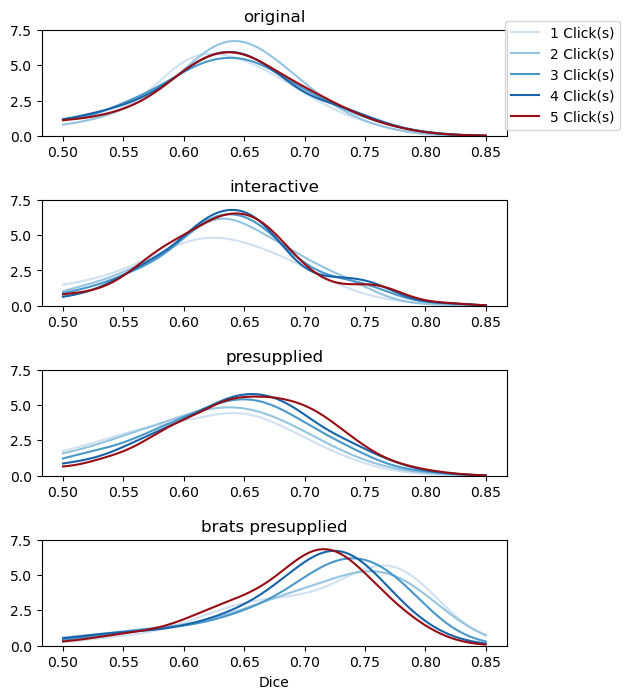

In [98]:

# Common plotting elements
n_click = 5
x_range = np.linspace(0.5, 0.85, 500)
color_start = 0.2  # Start from a darker shade
color_end = 1  # End before the darkest shade to keep a uniform intensity
colors = [cm.Blues(i / (n_click-1) * (color_end - color_start) + color_start) for i in range(n_click-1)]
colors.append(cm.Reds(0.9))

fig, ax = plt.subplots(len(diffs_dict),1, figsize = (6,8))
plt.subplots_adjust(hspace=0.6, right=0.9)

for i, (protocol, res) in enumerate(dice.items()):
    for click, diffs in res.items():
        kde = gaussian_kde(diffs)
        kde_values = kde(x_range)
        
        # Plot each row's KDE with a different color
        # ax.plot(x_range, kde_values, color=colors[click], label=f'{click+1} Click(s)')
        ax[i].plot(x_range, kde_values, color=colors[click], label=f'{click+1} Click(s)')

    # ax.set_title(protocol)
    # ax.set_xlabel(None)
    # ax.set_ylabel(None)
    # ax.set_ylim([0,7.5])

    ax[i].set_title(protocol)
    ax[i].set_xlabel(None)
    ax[i].set_ylabel(None)
    ax[i].set_ylim([0,7.5])

    if i == 0: 
        fig.legend(loc = 'upper right', bbox_to_anchor=(1.1, 0.9))

ax[i].set_xlabel('Dice')
plt.show()


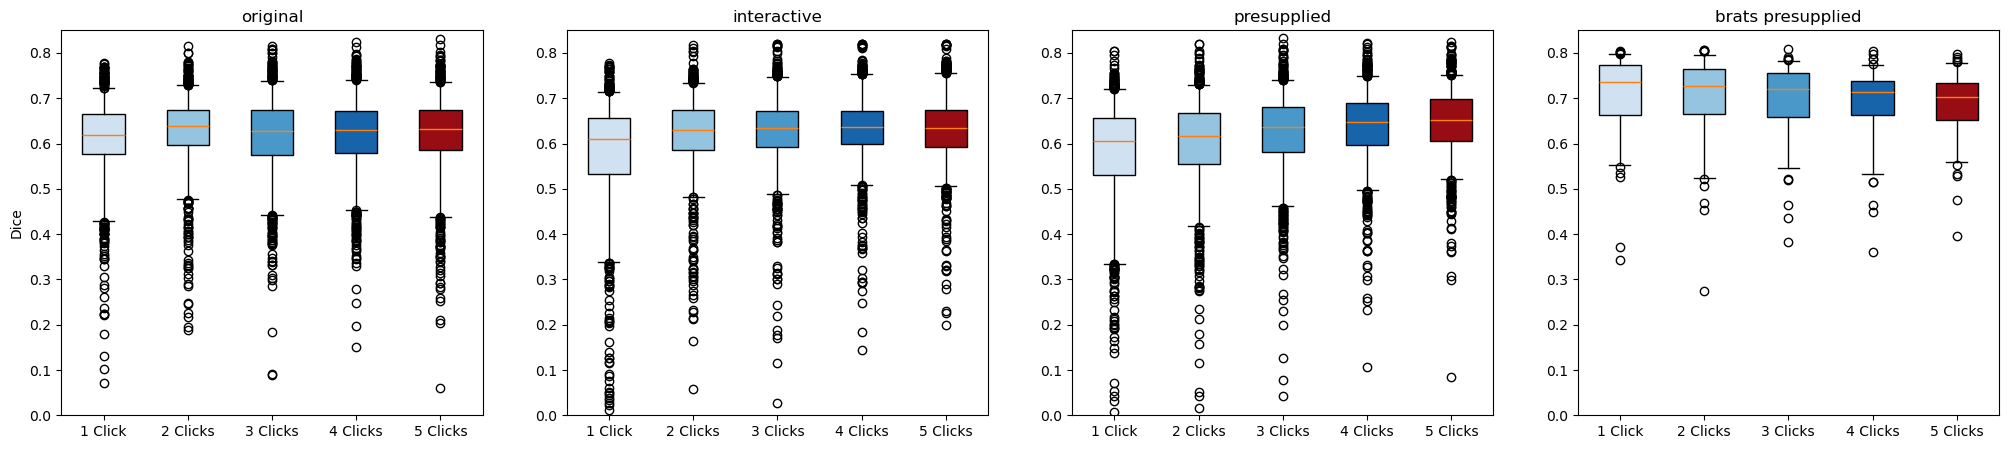

In [99]:
fig, ax = plt.subplots(1,4, figsize = (25,5))
for i, (protocol, data) in enumerate(dice.items()):
    data = np.array([data[0], data[1], data[2], data[3], data[4]]).T
    box = ax[i].boxplot(data, whis=[5,95], patch_artist=True)

    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    # Set the x-axis labels
    ax[i].set_xticklabels(['1 Click', '2 Clicks', '3 Clicks', '4 Clicks', '5 Clicks'])

    # Adding title and labels
    ax[i].set_title(protocol)
    ax[i].set_ylim([0,0.85])
    ax[i].set_ylabel(None)
    if i == 0:
        ax[i].set_ylabel('Dice')

# Show the plot
plt.show()
